Loading libraries for this notebook

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


Importing data and setting a test size

In [122]:
macro = pd.read_csv("../data/processed/macro_monthly_clean.csv", parse_dates=["date"])
macro = macro.sort_values("date").set_index("date").asfreq("MS")

# target
y = pd.to_numeric(macro["unrate"], errors="coerce")
y = y.dropna()
# choose test size (you pick)
TEST_SIZE = 36
y_train, y_test = y.iloc[:-TEST_SIZE], y.iloc[-TEST_SIZE:]

print("Index freq:", pd.infer_freq(y.index))
print("Train:", y_train.index.min(), "->", y_train.index.max(), "n=", len(y_train))
print("Test :", y_test.index.min(),  "->", y_test.index.max(),  "n=", len(y_test))

Index freq: MS
Train: 1976-06-01 00:00:00 -> 2022-12-01 00:00:00 n= 559
Test : 2023-01-01 00:00:00 -> 2025-12-01 00:00:00 n= 36


## Random Walk

Using a random walk model to forecast UNRATE. This will be used as a baseline to compare all the other models to. 

In [72]:
y_pred_rw = y.shift(1).loc[y_test.index]

rmse_rw = float(np.sqrt(np.mean((y_test - y_pred_rw) ** 2)))
mae_rw = float(np.mean(np.abs(y_test - y_pred_rw)))

print(f"RW RMSE: {rmse_rw:.3f}")
print(f"RW MAE:  {mae_rw:.3f}")

RW RMSE: 0.118
RW MAE:  0.092


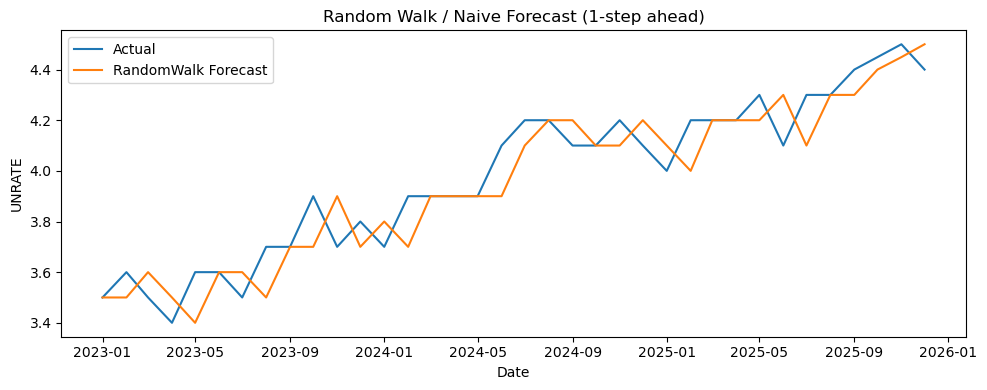

In [73]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred_rw.values, label="RandomWalk Forecast")
plt.title("Random Walk / Naive Forecast (1-step ahead)")
plt.xlabel("Date")
plt.ylabel("UNRATE")
plt.legend()
plt.tight_layout()
plt.show()

## Arima 


In [140]:
order = (2, 1, 0)
# can change according to need, reference ACF/PACF plots

### Simple Arima
Only using the traing data. 

In [141]:
model0 = SARIMAX(
    y_train,
    order=order,
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
)

res0 = model0.fit(disp=False)

fc0 =  res0.get_forecast(steps=TEST_SIZE)

y_pred_arima0 = fc0.predicted_mean

y_pred_arima0.index = y_test.index  

rmse_arima0 = float(np.sqrt(np.mean((y_test - y_pred_arima0) ** 2)))
mae_arima0 = float(np.mean(np.abs(y_test - y_pred_arima0))) 

print(f"ARIMA0{order} RMSE: {rmse_arima0:.3f}")
print(f"ARIMA0{order} MAE:  {mae_arima0:.3f}")



ARIMA0(2, 1, 0) RMSE: 0.694
ARIMA0(2, 1, 0) MAE:  0.593


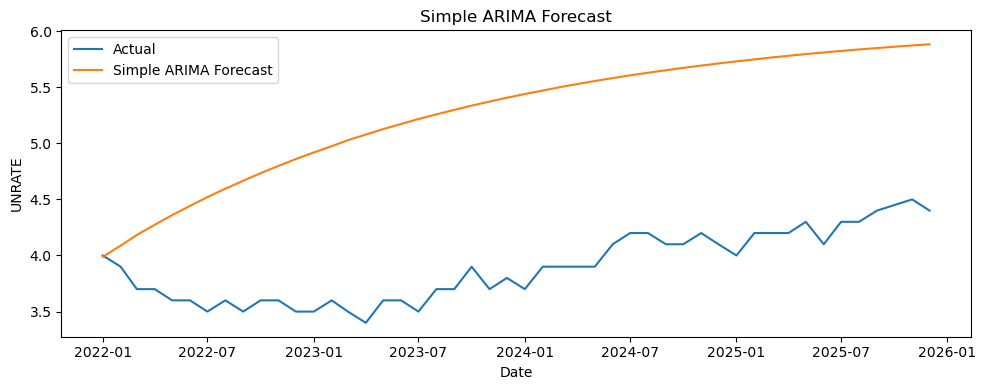

In [68]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred_arima0.values, label="Simple ARIMA Forecast")
plt.title("Simple ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("UNRATE")
plt.legend()
plt.tight_layout()
plt.show()

### Walk-forward ARIMA
Using a walk forward method

In [123]:
preds_arima1 = []

for t in y_test.index:
    y_fit = y.loc[:t].iloc[:-1]  # use all data up to t, excluding t itself

    model1 = SARIMAX(
        y_fit,
        order=order,
        trend="c",
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    res1 = model1.fit(disp=False, maxiter=200)

    fc1 = res1.get_forecast(steps=1)

    yhat_t = float(fc1.predicted_mean.iloc[0])  # get the forecast for time t

    preds_arima1.append(yhat_t)

y_pred_arima1 = pd.Series(preds_arima1, index=y_test.index, name="ARIMA1 Forecast")

rmse_arima1 = float(np.sqrt(np.mean((y_test - y_pred_arima1) ** 2)))   
mae_arima1 = float(np.mean(np.abs(y_test - y_pred_arima1)))

print(f"ARIMA1{order} RMSE: {rmse_arima1:.3f}")
print(f"ARIMA1{order} MAE:  {mae_arima1:.3f}")    

ARIMA1(1, 1, 1) RMSE: 0.128
ARIMA1(1, 1, 1) MAE:  0.103


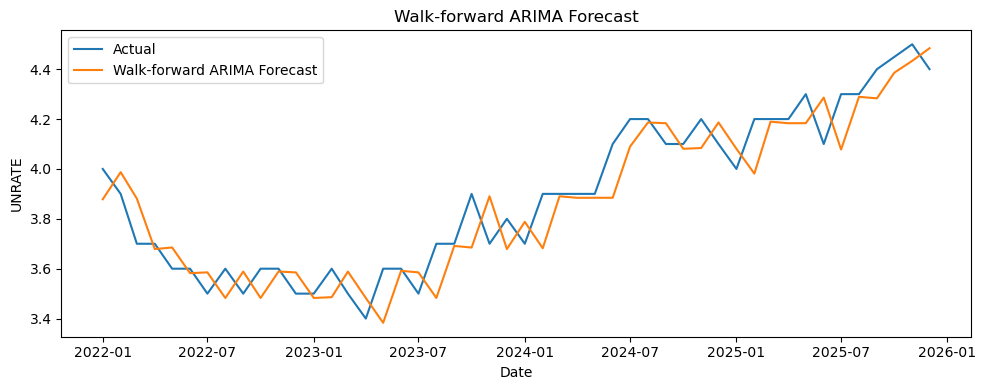

In [70]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred_arima1.values, label="Walk-forward ARIMA Forecast")
plt.title("Walk-forward ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("UNRATE")
plt.legend()
plt.tight_layout()
plt.show()

## ARIMAX

Using exogenous variables to predict UNRATE. 

In [133]:
# X setup
import numpy as np
import pandas as pd

# --- yield curve (level is fine) ---
macro["yc"] = pd.to_numeric(macro["t10y2y"], errors="coerce")

# --- industrial production growth (monthly % change) ---
indpro = pd.to_numeric(macro["indpro"], errors="coerce")
indpro = indpro.where(indpro > 0)  # avoid log(0) or log(neg)

macro["ip_g"] = 100 * np.log(indpro).diff()

# --- apply lags ---
LAG_YC = 9   # yield curve leads cycle
LAG_IP = 1   # short-term real activity

X = pd.concat(
    [
        macro["yc"].shift(LAG_YC),
        macro["ip_g"].shift(LAG_IP)
    ],
    axis=1
).rename(columns={
    "yc": "yc_l6",
    "ip_g": "ip_g_l1"
})

# combine and clean ONCE
data = pd.concat([y.rename("unrate"), X], axis=1)

# remove infs just in case, then drop any rows with missing y or X
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# final aligned series
y2 = data["unrate"]
X2 = data[["yc_l6", "ip_g_l1"]]

# split (now they will align)
TEST_SIZE = 36
y_train, y_test = y2.iloc[:-TEST_SIZE], y2.iloc[-TEST_SIZE:]
X_train, X_test = X2.iloc[:-TEST_SIZE], X2.iloc[-TEST_SIZE:]

print("NaNs in X_train?", X_train.isna().any().any())
print("Aligned?", y_train.index.equals(X_train.index))

NaNs in X_train? False
Aligned? True


In [94]:
print("NaNs in X_train?", X_train.isna().any().any())
print("Infs in X_train?", np.isinf(X_train.to_numpy()).any())
print("Aligned?", y_train.index.equals(X_train.index))
print(X_train.head(10))

NaNs in X_train? True
Infs in X_train? False
Aligned? False
               yc_l6   ip_g_l1
date                          
1976-06-01       NaN       NaN
1976-07-01       NaN       NaN
1976-08-01       NaN  0.567945
1976-09-01       NaN  0.685435
1976-10-01       NaN  0.345105
1976-11-01       NaN -0.030449
1976-12-01  0.801364  1.512734
1977-01-01  0.981905  1.075381
1977-02-01  1.137273 -0.702229
1977-03-01  1.178095  1.567567


In [125]:
arimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

arimax_res = arimax_model.fit(disp=False)

arimax_forecast = arimax_res.get_forecast(
    steps=len(y_test),
    exog=X_test
)

arimax_pred = arimax_forecast.predicted_mean

rmse_arimax = np.sqrt(mean_squared_error(y_test, arimax_pred))
print("ARIMAX RMSE:", round(rmse_arimax, 4))

ARIMAX RMSE: 0.4067


In [139]:
def walk_forward_arimax(y_train, y_test, X_train, X_test, order=(1,1,1)):
    # combine train+test so we can expand window smoothly
    y_all = pd.concat([y_train, y_test])
    X_all = pd.concat([X_train, X_test])

    preds = []
    pred_idx = []

    train_end = len(y_train)

    for i in range(train_end, len(y_all)):
        y_fit = y_all.iloc[:i]
        X_fit = X_all.iloc[:i]

        # 1-step-ahead exog row (must be 2D)
        X_next = X_all.iloc[i:i+1]

        model = SARIMAX(
            y_fit,
            exog=X_fit,
            order=order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=1, exog=X_next)
        preds.append(fc.predicted_mean.iloc[0])
        pred_idx.append(y_all.index[i])

    y_pred = pd.Series(preds, index=pred_idx, name="y_pred")
    y_true = y_test.loc[y_pred.index]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return y_pred, rmse

arimax_pred_wf, rmse_arimax_wf = walk_forward_arimax(
    y_train, y_test, X_train, X_test, order=(2,1,0)
)

print("Walk-forward ARIMAX RMSE:", round(rmse_arimax_wf, 4))

Walk-forward ARIMAX RMSE: 0.1441
